# Deep Q-Learning

https://arxiv.org/abs/1312.5602

In [1]:
from collections import deque
import random

import gymnasium as gym

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import IPython.display as display

## Models

In [2]:
class QNet(nn.Sequential):
    def __init__(self, obs_dim, hidden_size, act_dim):
        super().__init__(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, act_dim)
        )


class DQNAgent:
    def __init__(self, env, hidden_size=64, learning_rate=5e-4, epsilon=0.1, gamma=0.98):
        obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n
        self.epsilon = epsilon
        self.gamma = gamma

        self.q = QNet(obs_dim, hidden_size, self.act_dim)
        self.q_target = QNet(obs_dim, hidden_size, self.act_dim)

        self.optimizer = optim.Adam(self.q.parameters(), lr=learning_rate)

    def get_action(self, obs):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.act_dim)
        else:
            obs = torch.tensor(obs, dtype=torch.float32)
            q_values = self.q(obs)
            return torch.argmax(q_values).item()

    def update(self, obs, act, reward, next_obs, done):
        q_values = self.q(obs)
        q_value = q_values[torch.arange(obs.size(0)), act]

        with torch.no_grad():
            q_target_values = self.q_target(next_obs)
            q_target_value = reward + (1 - done) * self.gamma * torch.max(q_target_values, -1)[0]

        loss = nn.functional.mse_loss(q_value, q_target_value)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def sync(self):
        self.q_target.load_state_dict(self.q.state_dict())

## Train

In [3]:
def plot_loss(losses, rets):
    display.clear_output(True)

    plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(losses)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Loss')

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(rets)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Return')

    plt.show()


In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def push(self, obs, act, reward, next_obs, done):
        self.buffer.append((obs, act, reward, next_obs, int(done)))

    def __len__(self):
        return len(self.buffer)

    def get_batch(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        batch = random.sample(self.buffer, batch_size)
        return map(torch.tensor, zip(*batch))

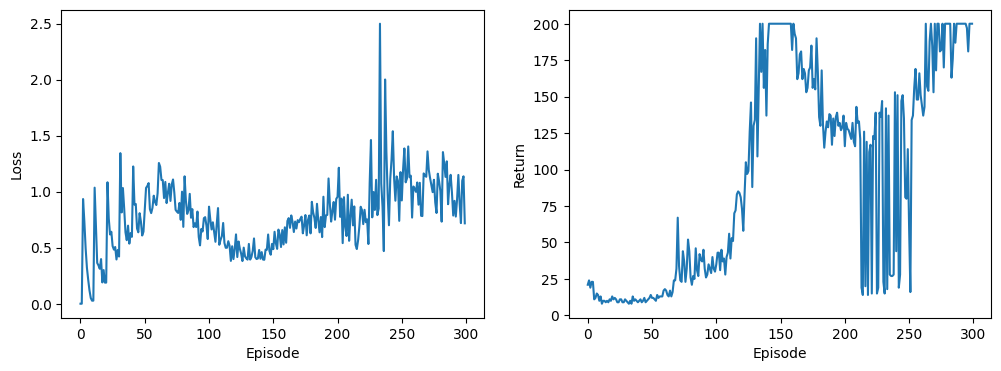

In [6]:
episodes = 300
batch_size = 50
sync_interval = 10
learning_rate = 3e-4
epsilon = 0.1

env = gym.make('CartPole-v0', render_mode='rgb_array')
agent = DQNAgent(env, epsilon=epsilon, learning_rate=learning_rate)
buffer = ReplayBuffer(10000, batch_size)

total_rewards = []
average_losses = []
for episode in range(episodes):
    obs, _ = env.reset()
    done = False

    total_reward = 0
    losses = []
    while not done:
        act = agent.get_action(obs)
        next_obs, reward, terminated, truncated, _ = env.step(act)
        done = terminated or truncated

        buffer.push(obs, act, reward, next_obs, done)
        if len(buffer) > batch_size:
            loss = agent.update(*buffer.get_batch())
            losses.append(loss)

        obs = next_obs
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync()

    total_rewards.append(total_reward)
    average_losses.append(np.mean(losses) if losses else 0)
    plot_loss(average_losses, total_rewards)


## Evaluate

In [7]:
def render(env):
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()
    display.clear_output(wait=True)

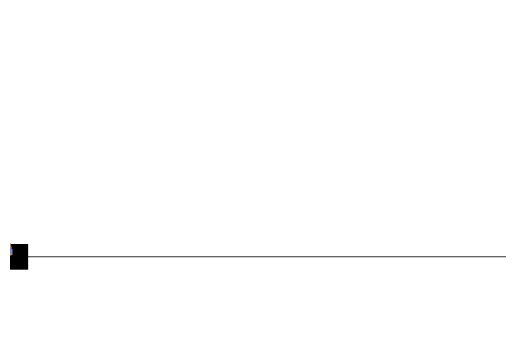

In [8]:
obs, _ = env.reset()
done = False
while not done:
    act = agent.get_action(obs)
    obs, _, terminated, truncated, _ = env.step(act)
    done = terminated or truncated
    render(env)